In [73]:
import duckdb
from glob import glob
import re
from os.path import basename

duckdb.sql("""
create or replace table coins (
    ts timestamptz,
    symbol text,
    close float,
    volume int64
);
create index ts_coins on coins(ts);
create index sym_coins on coins(symbol);
create unique index sym_ts_coins on coins(symbol, ts);
""")

stables = set(['dai','bsc-usd','busd','eurc','c1usd','susds','usd1','bfusd','fdusd','pyusd','rlusd','steakusdc','syrupusdc',
           'syrupusdt','tusd','usd0','usdai','usdb','usdc.e','usdc','usdd','usde','usdf',
           'usdg','usds','usdt','usdt0','usdtb','usdy'])
    
files = glob('pd-data/*.parquet')
#files = map(lambda c: f'pd-data/{c}.parquet', ['btc','eth','ada'])
coins = list(filter(lambda c: c not in stables, map(
    lambda f: re.search(r'(.+)\.parquet', basename(f)).group(1), files)))

for tick in coins:
    f = f'pd-data/{tick}.parquet'
    duckdb.read_parquet(f)
    duckdb.execute('delete from coins where symbol = ?', [tick])
    duckdb.execute(f'''
    insert into coins
    select distinct on (timestamp)
        timestamp as ts,
        asset as symbol,
        price as close,
        total_volume as volume
    from '{f}'
    order by timestamp,price
    ''')

lags = 60

duckdb.execute('''
create or replace table open as
select
        c.ts,
        c.symbol,
        c.close,
        -- crypto trades 24/7 yesterday's close = today's open
        cc.close as open,
        c.volume
    from coins c
    asof join coins cc
        on c.symbol = cc.symbol
        and cc.ts < c.ts
''');

duckdb.execute('''
    create or replace table momentum as 
    with params as (
        select unnest(range(1, ? + 1)) as lag
    )
    select
        td.ts,
        td.symbol,
        ln(td.close / td.open) as ret,
        p.lag,
        ln(td.open / hori.open) as mom
    from open td
    cross join params p
    asof join open hori
        on td.symbol = hori.symbol
        and hori.ts <= td.ts - (p.lag * interval '1 day')
    where td.close is not null 
      and td.open is not null
      and hori.close is not null
''', [lags])

duckdb.sql('''
create or replace table benchmark as
select
    year(ts) as year,
    ln(product(close / open)) as ret
from open
where symbol = 'btc'
group by year
''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [80]:
# v
# add vol z score
# add mcap
# add auto correlation
# add 60/5 ema
# encode crossing as triangle wave 0.01 0.1 1 (bullish cross) 0.1 0.01 and negative on bearish
# try linear models

duckdb.sql('''
create or replace table returns as
select
    year(ts) as year,
    symbol,
    lag,
    sum(ret) as ret
from momentum
where mom > 0
group by year, symbol, lag
''')

duckdb.sql('''
create or replace table cross_alpha as
select
    r.year,
    r.lag,
    avg(r.ret - b.ret) as ret
from returns r
join benchmark b
  on b.year = r.year
group by r.year, r.lag
''')

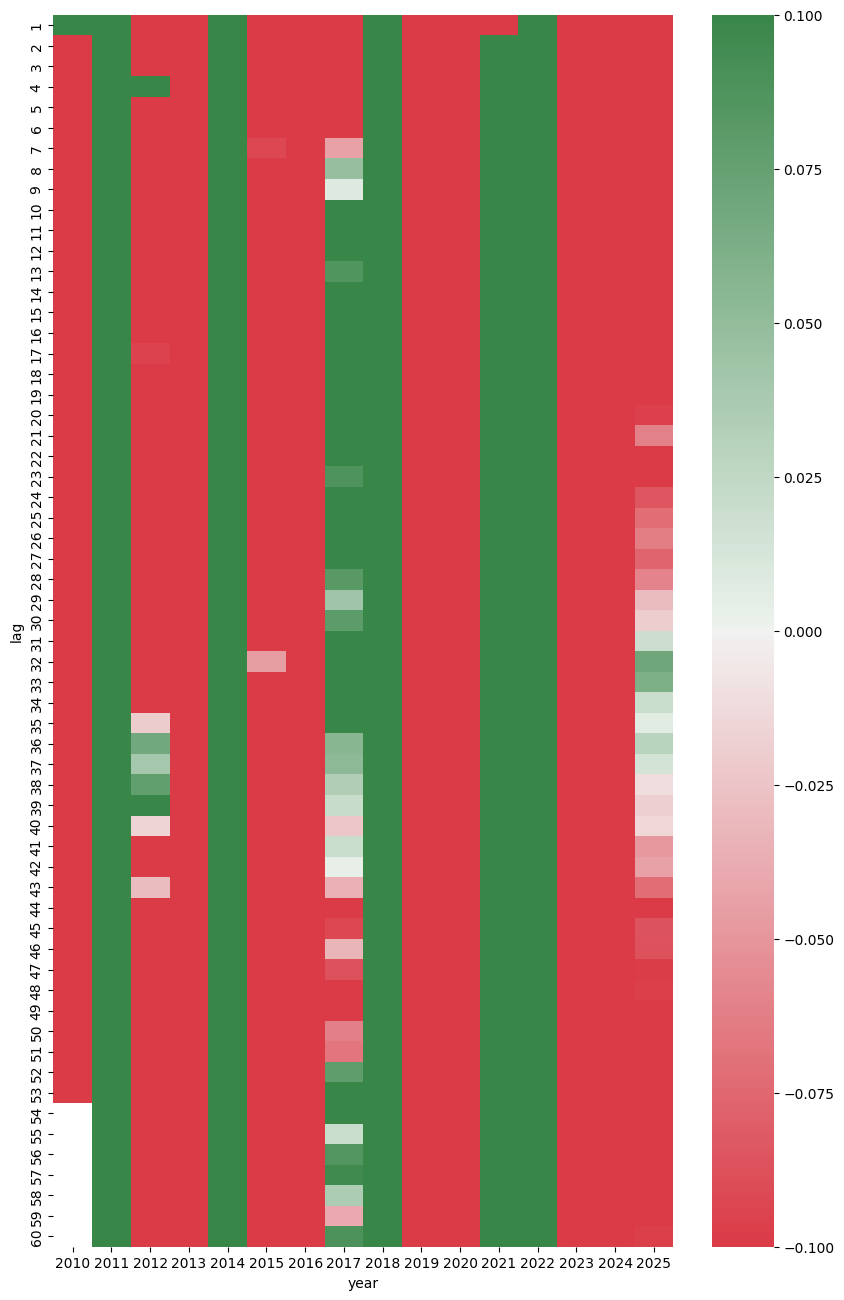

In [82]:
# cross sectional performance for each lag by year

import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

df = duckdb.sql('''
    select
        year,
        lag,
        ret
    from cross_alpha
    
''').df()

df.year = df.year.astype(str)
df = df.pivot_table(index='lag', columns='year', values='ret')

fig, ax = plt.subplots(figsize=(10, 16))
cm = sns.diverging_palette(h_neg=10, h_pos=133, s=75, l=50, as_cmap=True)

sns.heatmap(
    df,
    ax=ax,
    #mask=arr < 0,
    vmin=-np.max(np.abs(arr)),
    vmax=np.max(np.abs(arr)),
    cmap=cm)
plt.show()

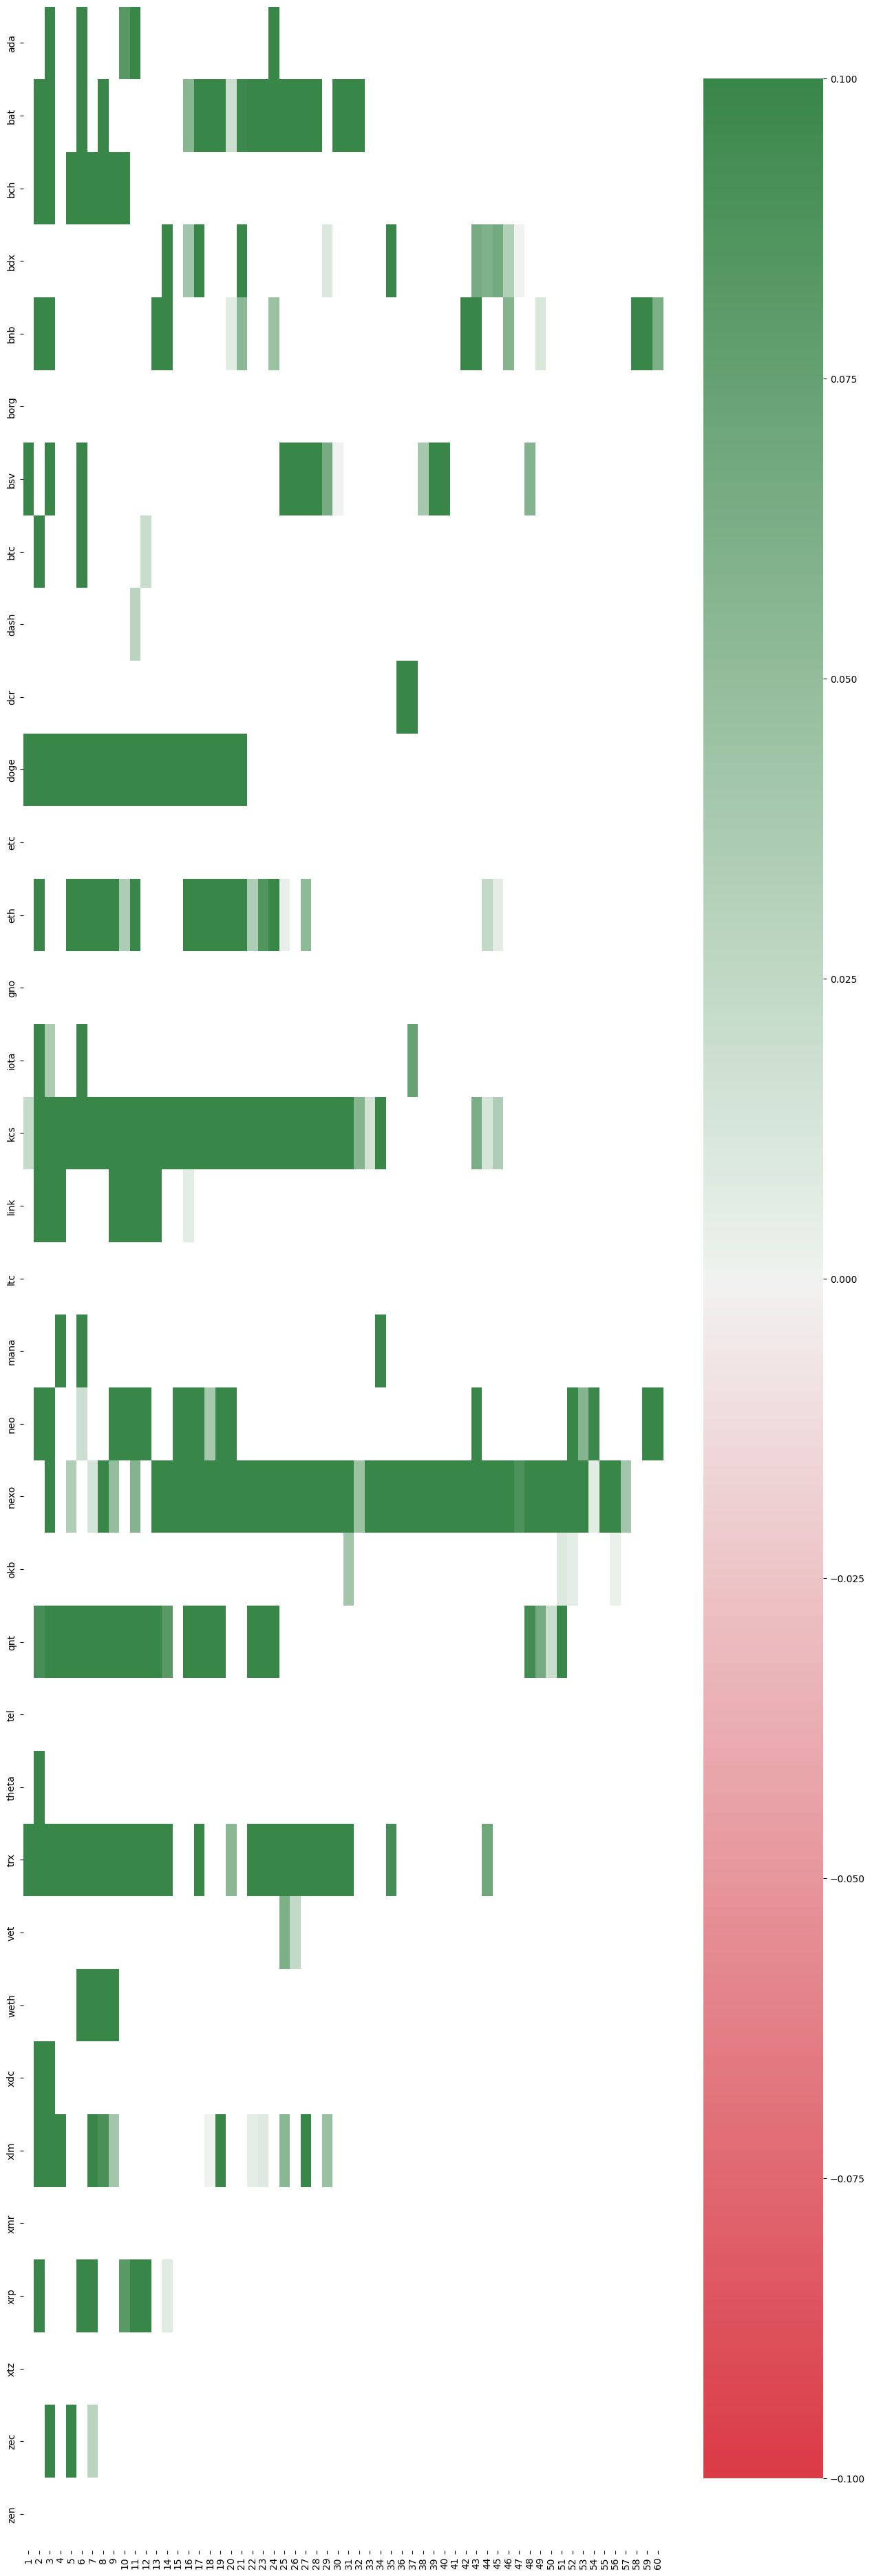

In [38]:
# performance heatmap of all lags per coin 

year = '2018'

import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

df = duckdb.execute('''
    select
        symbol,
        lag,
        ret
    from returns
    where year = ?
''', [year]).df()

syms = sorted(list(df.symbol.unique()))
arr = np.full((len(syms), np.max(df.lag)), np.nan)

for (_, row) in df.iterrows():
    arr[syms.index(row.symbol), row.lag-1] = row.ret

fig, ax = plt.subplots(figsize=(15, 48))
cm = sns.diverging_palette(h_neg=10, h_pos=133, s=75, l=50, as_cmap=True)

sns.heatmap(
    arr,
    ax=ax,
    mask=arr < 0,
    vmin=-np.max(np.abs(arr)),
    vmax=np.max(np.abs(arr)),
    cmap=cm)

ax.set_xticklabels(range(1, np.max(df.lag) + 1))
ax.set_yticklabels(syms)
plt.show()

In [169]:
lagexpr = [f'''
    sum(logret) over (
        partition by symbol
        order by ts rows
        between {p} preceding and 0 following
        exclude current row
    )
    ''' for p in range(1,lags + 1)]

duckdb.sql(f'''
create or replace table metrics (
    ts timestamptz,
    symbol text,
    logret float,  -- return AFTER this day
    relvol float,  -- relative vol
    lags float[{lags}]
);
create index ts_metrics on metrics(ts);
create index sym_metrics on metrics(symbol);
create unique index sym_ts_metrics on metrics(symbol, ts);

create or replace table total_volume (
    ts timestamptz,
    volume float
);
create unique index ts_total_volume on total_volume(ts);
''')

duckdb.execute('''
insert into total_volume
select
    ts,
    sum(volume) as v
from coins
group by ts
''');

duckdb.execute(f'''
with rel_volume as (
    select
        coins.ts,
        symbol,
        coins.volume / total_volume.volume as relvol
    from coins
    join total_volume on coins.ts = total_volume.ts
), returns as (
    select
        ts,
        symbol,
        close / lag(close) over (partition by symbol order by ts) as ret
    from coins
), log_returns as (
    select
        ts,
        symbol,
        ln(ret) as logret
    from returns
), lags as (
    select
        ts,
        symbol,
        [{",".join(lagexpr)}] as lags
    from log_returns
)
insert into metrics
select
    rv.ts,
    rv.symbol,
    lr.logret,
    rv.relvol,
    l.lags
from rel_volume rv
join lags l on rv.ts = l.ts and rv.symbol = l.symbol
join log_returns lr on rv.ts = lr.ts and rv.symbol = lr.symbol
''')

In [9]:
# hyperparameters
# lag
# folio size/cutoff
# tracking error


import polars as pl
import numpy as np
import functools as fc
import matplotlib.pyplot as plt
import pandas as pd

index = duckdb.sql('select distinct ts from metrics order by ts asc''').df()

res = pd.DataFrame(
    {f'weights{lb}d': [{} for _ in range(0, len(index.ts))] for lb in [1,7,14]} |
    {f'return{lb}d': [0.0 for _ in range(0, len(index.ts))] for lb in [1,7,14]},
    index=index.ts)

for ts in index.ts:
    for lb in [1,7,14]:
        m = duckdb.execute(f'''
            select
                m.ts,
                m.symbol,
                m.logret,          -- today's return (close to close)
                mm.relvol,         -- yesterday's relative volume
                m.lags[{lb}] as lag   -- today's metric (previous n-day return)
            from metrics m
            inner join metrics mm
                on mm.ts = m.ts - interval '1 day' and mm.symbol = m.symbol
            where m.ts = ?
              and lag > 0
              and mm.relvol <> 'NaN'::float and mm.relvol > 0
              and m.symbol in ?
            order by mm.relvol desc
        ''', [ts, ['btc','eth','ada']]).df().set_index('symbol')
        
        # weights are yesterdays relative volume in the winner bucket
        relvol = np.sum(m.relvol.values)
        weights = {r.Index: r.relvol / relvol for r in m.itertuples()}
                
        # weights must sum to zero
        assert len(weights) == 0 or np.isclose(1, sum(weights.values()))
        
        res.loc[ts, [f'weights{lb}d']] = [weights]
    
        # eod return based on weights
        weight_logret = lambda logret, weight: np.log(((np.exp(logret) - 1) * weight) + 1)
        res.loc[ts, f'return{lb}d'] = \
            np.sum([weight_logret(m.loc[w[0]].logret, w[1]) for w in weights.items()])        

res

,weights1d,weights7d,weights14d,return1d,return7d,return14d
ts,,,,,,
2010-11-07 00:00:00+08:00,{},{},{},0.000000,0.000000,0.000000
2010-11-08 00:00:00+08:00,{},{},{},0.000000,0.000000,0.000000
2010-11-09 00:00:00+08:00,{'btc': 1.0},{'btc': 1.0},{'btc': 1.0},0.129831,0.129831,0.129831
2010-11-10 00:00:00+08:00,{'btc': 1.0},{'btc': 1.0},{'btc': 1.0},0.222212,0.222212,0.222212
2010-11-11 00:00:00+08:00,{'btc': 1.0},{'btc': 1.0},{'btc': 1.0},-0.080976,-0.080976,-0.080976
...,...,...,...,...,...,...
2025-11-14 00:00:00+08:00,{},{'ada': 1.0},{},0.000000,-0.063242,0.000000
2025-11-15 00:00:00+08:00,{},{},{},0.000000,0.000000,0.000000
2025-11-16 00:00:00+08:00,"{'btc': 0.6628599, 'eth': 0.32556438, 'ada': 0...",{},{},-0.016998,0.000000,0.000000


<Axes: xlabel='ts'>

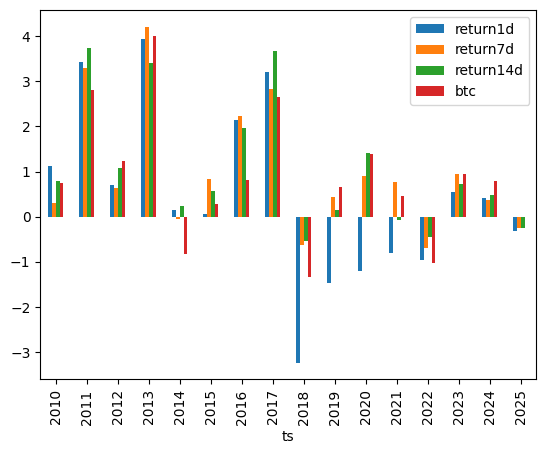

In [10]:
df = res.join(
    duckdb.execute('''
        select
            ts,
            logret as btc
        from metrics
        where symbol = 'btc'
        order by ts asc
    ''').df().set_index('ts'),
    on='ts',
    how='inner')

w = df[[f'return{lb}d' for lb in [1,7,14]] + ['btc']].groupby(df.index.year)
#res1['ir'] = (res1.logret - res1.btc) / res1.logret.expanding().sum()
#res1['bench'] = res1.btc.expanding().sum()

#plt.plot(res1.index, res1.cumret, label='momentum', color='blue')
#plt.plot(res1.index, res1.bench, label='benchmark', color='orange')

w.sum().plot(kind='bar')

lag
36    20
31    19
33    17
2     14
32    12
6     12
1     11
35     9
13     9
7      8
3      8
34     8
4      7
21     7
30     7
14     6
28     6
15     6
17     5
8      5
11     4
16     4
5      3
29     3
22     3
19     3
24     3
25     2
10     2
12     2
26     2
9      2
20     2
27     1
Name: count, dtype: int64


ValueError: The number of FixedLocator locations (18), usually from a call to set_ticks, does not match the number of labels (36).

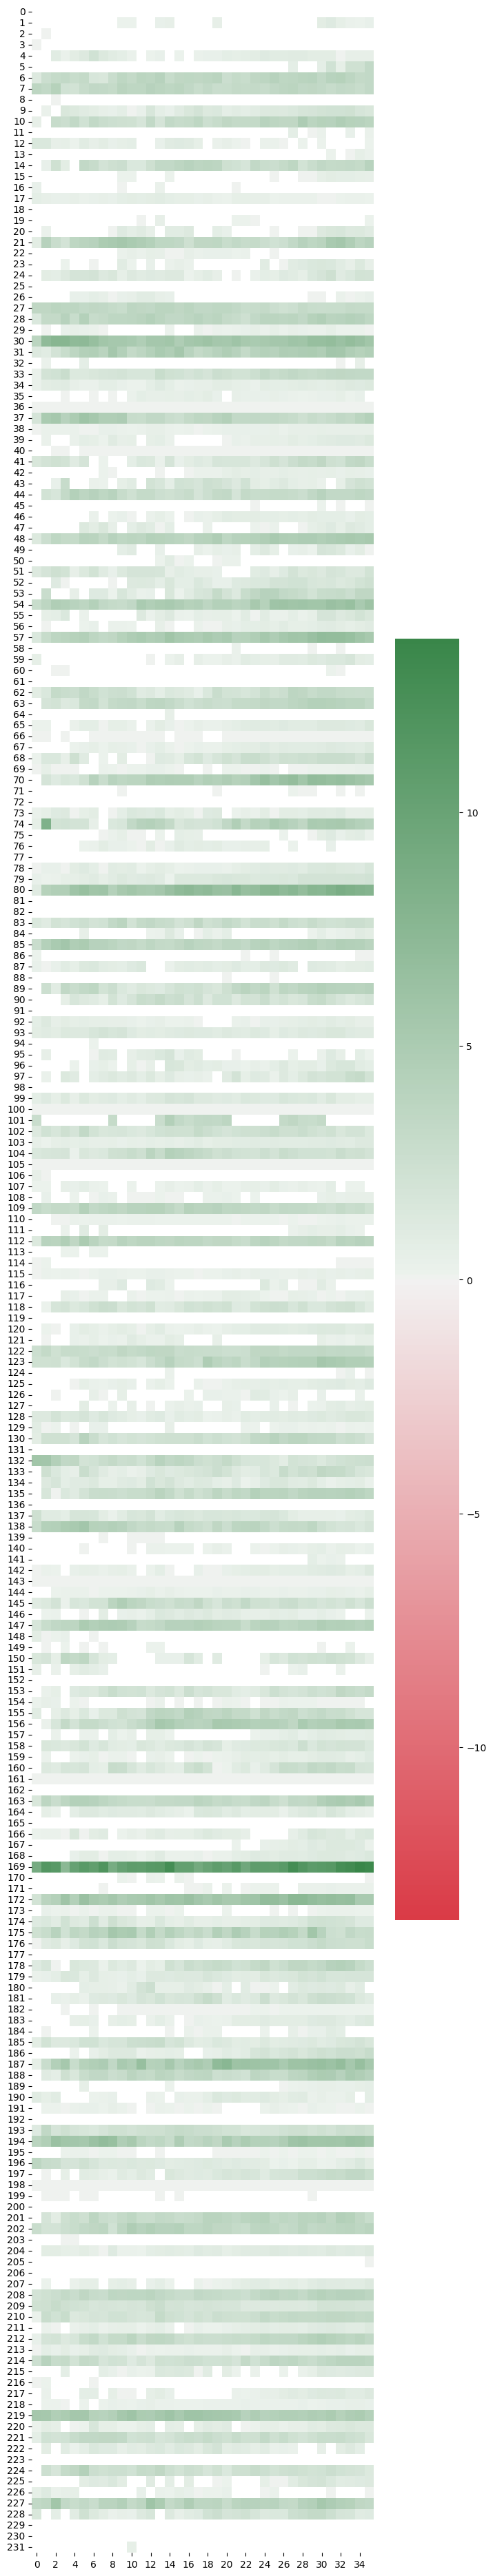

In [170]:
import seaborn as sns
import matplotlib.pylab as plt

df = duckdb.sql('''
    with strategies as (
        select
            m.ts,
            m.symbol,
            apply(m.lags, lambda lag: if(lag > 0, m.logret, 0)) as logret
        from metrics m
        where m.ts >= '2020-01-01'
    ), flat as (
        select
            s.ts,
            s.symbol,
            unnest(s.logret) as logret,
            generate_subscripts(s.logret, 1) as lag
        from strategies s
    )
    select
        f.symbol,
        f.lag,
        sum(f.logret) as logret
    from flat f
    group by f.symbol, f.lag
''',).df()

print(df.loc[df.groupby('symbol').logret.idxmax()].lag.value_counts().sort_values(ascending=False))
    

syms = sorted(list(df.symbol.unique()))
arr = np.full((len(syms), np.max(df.lag)), np.nan)

for (_, row) in df.iterrows():
    arr[syms.index(row.symbol), row.lag-1] = row.logret

fig, ax = plt.subplots(figsize=(8, 48))
cm = sns.diverging_palette(h_neg=10, h_pos=133, s=75, l=50, as_cmap=True)

sns.heatmap(
    arr,
    ax=ax,
    mask=arr < 0,
    vmin=-np.max(np.abs(arr)),
    vmax=np.max(np.abs(arr)),
    cmap=cm)

ax.set_xticklabels(range(1, np.max(df.lag) + 1))
ax.set_yticklabels(syms)
plt.show()

<Axes: >

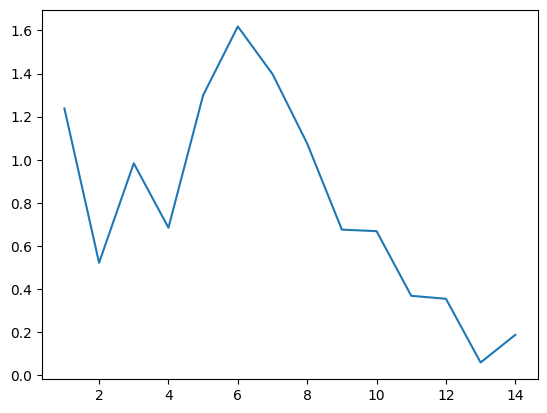

In [92]:
from matplotlib import pyplot as plt

res = pd.DataFrame(index=range(1,15),columns=['strategy','bench','alpha'])

for lb in range(1, 15):
    df = duckdb.execute('''
        select
            m.ts,
            cc.close as open,
            m.logret,
            m.lags[?] as mom
        from metrics m
        join coins cc on cc.ts = m.ts - interval '1 day' and cc.symbol = m.symbol
        where m.symbol = 'pump'
        order by m.ts asc
    ''', [lb]).df().set_index('ts')
    
    ss = df.loc['2024']
    ss['log'] = np.log(df.open)
    ss['bull'] = df.mom > 0
    ret = sum(ss[ss.bull].logret) - ss.iloc[0].logret

    res.loc[lb].bench = sum(ss.logret) - ss.iloc[0].logret
    res.loc[lb].strategy = ret

res.alpha = res.strategy - res.bench 
res.alpha.plot()

stra=1.1307951211929321, bench=1.3959277868270874, alpha=-0.2651326656341553


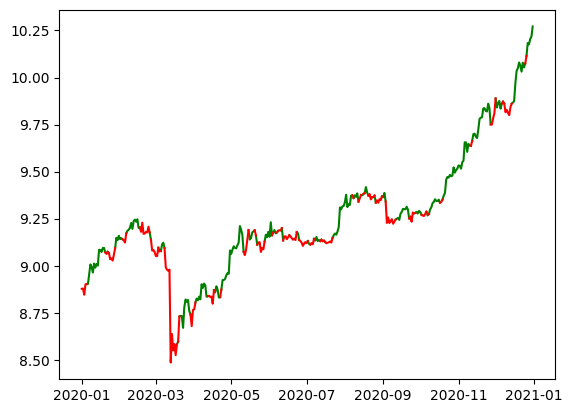

In [78]:
def plot_bull_bear(df, value_col, indicator_col):
    x = []
    y_bull = []
    y_bear = []
    
    for i in range(1, len(df)):
        ts, crow = df.index[i], df.iloc[i]
        yd, prow = df.index[i-1], df.iloc[i-1]
    
        x += [yd, ts]
        if prow[indicator_col]:
            y_bull += [prow[value_col], crow[value_col]]
            y_bear += [np.nan, np.nan]
        else:
            y_bull += [np.nan, np.nan]
            y_bear += [prow[value_col], crow[value_col]]
    
    plt.plot(x,y_bull,color='green')
    plt.plot(x,y_bear,color='red')

print(f'stra={stra}, bench={bench}, alpha={stra-bench}')

plot_bull_bear(ss, 'log', 'bull')

In [76]:
stra = sum(ss[ss.bull].logret) - ss.iloc[0].logret
bench = sum(ss.logret) - ss.iloc[0].logret
print(f'stra={stra}, bench={bench}, alpha={stra-bench}')

stra=0.5118719935417175, bench=1.3959277868270874, alpha=-0.8840557932853699
